In [1]:
# importing the neccessary libary
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import matplotlib.pyplot as plt
import time
from torch import autograd
from piqa import SSIM

In [2]:
# Downloading the MINST Dataset
transform =  transforms.ToTensor()


trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True) # Creating dataloader
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False)

In [3]:
# Vanilla AutoEncoder

#Encoder
class Q_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(Q_net, self).__init__()
        self.lin1 = nn.Linear(X_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3gauss = nn.Linear(N, z_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = F.relu(x)
        xgauss = self.lin3gauss(x)
        return xgauss

# Decoder
class P_net(nn.Module):  
    def __init__(self,X_dim,N,z_dim):
        super(P_net, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, X_dim)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = self.lin3(x)
        return F.sigmoid(x)
    
# Discriminator
class D_net_gauss(nn.Module):  
    def __init__(self,N,z_dim):
        super(D_net_gauss, self).__init__()
        self.lin1 = nn.Linear(z_dim, N)
        self.lin2 = nn.Linear(N, N)
        self.lin3 = nn.Linear(N, 2)
    def forward(self, x):
        x = F.dropout(self.lin1(x))
        x = F.relu(x)
        x = F.dropout(self.lin2(x))
        x = F.relu(x)
        return F.sigmoid(self.lin3(x)) 

In [4]:
EPS = 1e-15
z_red_dims = 2
encoder = Q_net(784,1000,z_red_dims)
decoder = P_net(784,1000,z_red_dims)
Disc = D_net_gauss(500,z_red_dims)

In [5]:
# Set learning rates
gen_lr = 0.0001
reg_lr = 0.00005

In [6]:
#encode/decode optimizers
optim_decoder = torch.optim.Adam(decoder.parameters(), lr=gen_lr)
optim_encoder = torch.optim.Adam(encoder.parameters(), lr=gen_lr)
#regularizing optimizers
optim_encoder_reg = torch.optim.Adam(encoder.parameters(), lr=reg_lr)
optim_D = torch.optim.Adam(Disc.parameters(), lr=reg_lr)

In [7]:
# Defining the Number of Epochs 
num_epochs = 100

# # Binary Cross Entropy Loss Function 

In [22]:
ae_criterion1 = nn.BCELoss()
train_loss1 = []
disc_loss1=[]
output1=[]

In [23]:
def BCE_training(encoder, decoder, Disc, dataloader, optim_encoder, optim_decoder, optim_D, train):
    total_rec_loss = 0
    total_disc_loss = 0
    total_gen_loss = 0
    if train:
        encoder.train()
        decoder.train()
        Disc.train()
    else:
        encoder.eval()
        decoder.eval()
        Disc.eval()

    for i, (data, labels) in enumerate(dataloader):
        """ Reconstruction loss """
        for p in Disc.parameters():
            p.requires_grad = False

        real_data_v = autograd.Variable(data)
        real_data_v = real_data_v.view(-1, 784)
        #print(real_data_v.size())
        encoding = encoder(real_data_v)
        fake = decoder(encoding)
        ae_loss = ae_criterion1(fake, real_data_v)
        total_rec_loss += ae_loss.item()
        if train:
            optim_encoder.zero_grad()
            optim_decoder.zero_grad()
            ae_loss.backward()
            optim_encoder.step()
            optim_decoder.step()

        """ Discriminator loss """
        encoder.eval()
        z_real_gauss = autograd.Variable(torch.randn(data.size()[0], 2) * 5.)
        D_real_gauss = Disc(z_real_gauss)

        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
        total_disc_loss += D_loss.item()

        if train:
            optim_D.zero_grad()
            D_loss.backward()
            optim_D.step()

        """ Generator loss """
        if train:
            encoder.train()
        else:
            encoder.eval()
        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))
        total_gen_loss += G_loss.item()

        if train:
            optim_encoder_reg.zero_grad()
            G_loss.backward()
            optim_encoder_reg.step()


        if i % 100 == 0:
            print ('\n Step [%d], recon_loss: %.4f, discriminator_loss :%.4f , generator_loss:%.4f'
                    %(i, ae_loss.item(), D_loss.item(), G_loss.item()))
            output1.append((epoch, data, fake))
    M = len(dataloader.dataset)
    return total_rec_loss /M  , total_disc_loss /M , total_gen_loss /M

In [24]:

for epoch in range(num_epochs):
    l1,l2 ,l3 = BCE_training(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D, True)
    print('\n epoch:{} ---- training loss1:{}'.format(epoch, l1))
    train_loss1.append(l1)
    disc_loss1.append(l2)


 Step [0], recon_loss: 0.1950, discriminator_loss :1.6974 , generator_loss:0.4665

 Step [100], recon_loss: 0.1966, discriminator_loss :1.8226 , generator_loss:0.5326

 Step [200], recon_loss: 0.2023, discriminator_loss :1.8562 , generator_loss:0.4895

 Step [300], recon_loss: 0.2150, discriminator_loss :1.6879 , generator_loss:0.5140

 Step [400], recon_loss: 0.1988, discriminator_loss :1.6677 , generator_loss:0.5355

 Step [500], recon_loss: 0.2101, discriminator_loss :1.9074 , generator_loss:0.4597

 Step [600], recon_loss: 0.2073, discriminator_loss :1.8336 , generator_loss:0.4720

 Step [700], recon_loss: 0.2058, discriminator_loss :1.9542 , generator_loss:0.4467

 Step [800], recon_loss: 0.1929, discriminator_loss :1.8779 , generator_loss:0.5087

 Step [900], recon_loss: 0.2023, discriminator_loss :1.7710 , generator_loss:0.4163

 epoch:0 ---- training loss1:0.003216962872693936

 Step [0], recon_loss: 0.2060, discriminator_loss :2.0199 , generator_loss:0.5082

 Step [100], reco


 Step [200], recon_loss: 0.2036, discriminator_loss :2.0291 , generator_loss:0.5011

 Step [300], recon_loss: 0.1930, discriminator_loss :2.1651 , generator_loss:0.4445

 Step [400], recon_loss: 0.2079, discriminator_loss :2.0058 , generator_loss:0.5125

 Step [500], recon_loss: 0.2135, discriminator_loss :2.0984 , generator_loss:0.4863

 Step [600], recon_loss: 0.2028, discriminator_loss :2.0431 , generator_loss:0.4709

 Step [700], recon_loss: 0.2134, discriminator_loss :1.9291 , generator_loss:0.4716

 Step [800], recon_loss: 0.2120, discriminator_loss :2.1678 , generator_loss:0.5085

 Step [900], recon_loss: 0.1927, discriminator_loss :1.9745 , generator_loss:0.4842

 epoch:9 ---- training loss1:0.003135988443096479

 Step [0], recon_loss: 0.1855, discriminator_loss :2.2691 , generator_loss:0.4967

 Step [100], recon_loss: 0.2009, discriminator_loss :2.3418 , generator_loss:0.4602

 Step [200], recon_loss: 0.1928, discriminator_loss :2.0360 , generator_loss:0.4706

 Step [300], re


 Step [400], recon_loss: 0.2112, discriminator_loss :2.1431 , generator_loss:0.4804

 Step [500], recon_loss: 0.1890, discriminator_loss :2.4349 , generator_loss:0.4285

 Step [600], recon_loss: 0.1989, discriminator_loss :2.2806 , generator_loss:0.3785

 Step [700], recon_loss: 0.2034, discriminator_loss :2.1590 , generator_loss:0.5150

 Step [800], recon_loss: 0.1996, discriminator_loss :2.1557 , generator_loss:0.4140

 Step [900], recon_loss: 0.2011, discriminator_loss :1.9673 , generator_loss:0.4807

 epoch:18 ---- training loss1:0.0031004007366796336

 Step [0], recon_loss: 0.1971, discriminator_loss :2.1807 , generator_loss:0.3967

 Step [100], recon_loss: 0.2020, discriminator_loss :2.3181 , generator_loss:0.5273

 Step [200], recon_loss: 0.1974, discriminator_loss :2.2759 , generator_loss:0.4782

 Step [300], recon_loss: 0.2071, discriminator_loss :2.1040 , generator_loss:0.4598

 Step [400], recon_loss: 0.1908, discriminator_loss :2.1191 , generator_loss:0.4746

 Step [500], 


 Step [600], recon_loss: 0.1952, discriminator_loss :2.1503 , generator_loss:0.4829

 Step [700], recon_loss: 0.1919, discriminator_loss :2.4065 , generator_loss:0.4509

 Step [800], recon_loss: 0.2047, discriminator_loss :2.4691 , generator_loss:0.5010

 Step [900], recon_loss: 0.2006, discriminator_loss :2.1047 , generator_loss:0.5582

 epoch:27 ---- training loss1:0.0030875614039599895

 Step [0], recon_loss: 0.1881, discriminator_loss :2.2174 , generator_loss:0.4108

 Step [100], recon_loss: 0.2016, discriminator_loss :2.1075 , generator_loss:0.4257

 Step [200], recon_loss: 0.1850, discriminator_loss :2.1742 , generator_loss:0.4946

 Step [300], recon_loss: 0.2064, discriminator_loss :2.1690 , generator_loss:0.3817

 Step [400], recon_loss: 0.1995, discriminator_loss :2.0103 , generator_loss:0.3790

 Step [500], recon_loss: 0.2058, discriminator_loss :2.0482 , generator_loss:0.4871

 Step [600], recon_loss: 0.1946, discriminator_loss :2.1857 , generator_loss:0.4913

 Step [700], 


 Step [800], recon_loss: 0.2054, discriminator_loss :2.3416 , generator_loss:0.4534

 Step [900], recon_loss: 0.1979, discriminator_loss :2.2720 , generator_loss:0.5333

 epoch:36 ---- training loss1:0.00308069712271293

 Step [0], recon_loss: 0.1905, discriminator_loss :2.3560 , generator_loss:0.4556

 Step [100], recon_loss: 0.1981, discriminator_loss :2.3683 , generator_loss:0.4135

 Step [200], recon_loss: 0.2012, discriminator_loss :2.4597 , generator_loss:0.4220

 Step [300], recon_loss: 0.1848, discriminator_loss :2.3040 , generator_loss:0.5491

 Step [400], recon_loss: 0.1900, discriminator_loss :2.2956 , generator_loss:0.4132

 Step [500], recon_loss: 0.1927, discriminator_loss :2.3501 , generator_loss:0.4217

 Step [600], recon_loss: 0.2046, discriminator_loss :1.9038 , generator_loss:0.4984

 Step [700], recon_loss: 0.1975, discriminator_loss :2.4700 , generator_loss:0.5342

 Step [800], recon_loss: 0.2078, discriminator_loss :2.0841 , generator_loss:0.4461

 Step [900], re


 epoch:45 ---- training loss1:0.0030748031809926034

 Step [0], recon_loss: 0.1950, discriminator_loss :2.2117 , generator_loss:0.4834

 Step [100], recon_loss: 0.1916, discriminator_loss :2.0898 , generator_loss:0.5238

 Step [200], recon_loss: 0.1966, discriminator_loss :2.3878 , generator_loss:0.4794

 Step [300], recon_loss: 0.2045, discriminator_loss :2.2873 , generator_loss:0.4943

 Step [400], recon_loss: 0.1903, discriminator_loss :2.1426 , generator_loss:0.4399

 Step [500], recon_loss: 0.1968, discriminator_loss :2.3761 , generator_loss:0.5271

 Step [600], recon_loss: 0.1924, discriminator_loss :2.4726 , generator_loss:0.4415

 Step [700], recon_loss: 0.2077, discriminator_loss :2.4746 , generator_loss:0.3507

 Step [800], recon_loss: 0.2071, discriminator_loss :2.1691 , generator_loss:0.4082

 Step [900], recon_loss: 0.1967, discriminator_loss :2.2420 , generator_loss:0.4661

 epoch:46 ---- training loss1:0.0030740484928091366

 Step [0], recon_loss: 0.1964, discriminator_


 Step [100], recon_loss: 0.2092, discriminator_loss :2.1699 , generator_loss:0.4600

 Step [200], recon_loss: 0.2071, discriminator_loss :2.1405 , generator_loss:0.4338

 Step [300], recon_loss: 0.1923, discriminator_loss :2.1672 , generator_loss:0.4282

 Step [400], recon_loss: 0.2065, discriminator_loss :2.1556 , generator_loss:0.5080

 Step [500], recon_loss: 0.2125, discriminator_loss :2.4753 , generator_loss:0.5439

 Step [600], recon_loss: 0.1935, discriminator_loss :1.9690 , generator_loss:0.4918

 Step [700], recon_loss: 0.1969, discriminator_loss :2.2203 , generator_loss:0.5562

 Step [800], recon_loss: 0.2038, discriminator_loss :2.2460 , generator_loss:0.4543

 Step [900], recon_loss: 0.2026, discriminator_loss :2.1843 , generator_loss:0.5540

 epoch:55 ---- training loss1:0.0030669946757455667

 Step [0], recon_loss: 0.1865, discriminator_loss :2.0428 , generator_loss:0.4125

 Step [100], recon_loss: 0.1863, discriminator_loss :2.0408 , generator_loss:0.4751

 Step [200], 


 Step [300], recon_loss: 0.1988, discriminator_loss :2.3140 , generator_loss:0.3607

 Step [400], recon_loss: 0.2029, discriminator_loss :2.3674 , generator_loss:0.5016

 Step [500], recon_loss: 0.2010, discriminator_loss :2.2567 , generator_loss:0.4570

 Step [600], recon_loss: 0.2087, discriminator_loss :2.3322 , generator_loss:0.3939

 Step [700], recon_loss: 0.1886, discriminator_loss :2.2546 , generator_loss:0.4487

 Step [800], recon_loss: 0.2027, discriminator_loss :2.2422 , generator_loss:0.5188

 Step [900], recon_loss: 0.1964, discriminator_loss :2.2016 , generator_loss:0.3634

 epoch:64 ---- training loss1:0.003062001923968395

 Step [0], recon_loss: 0.1991, discriminator_loss :2.2542 , generator_loss:0.4228

 Step [100], recon_loss: 0.1890, discriminator_loss :2.1659 , generator_loss:0.5982

 Step [200], recon_loss: 0.1927, discriminator_loss :2.2512 , generator_loss:0.5464

 Step [300], recon_loss: 0.1884, discriminator_loss :2.4876 , generator_loss:0.4504

 Step [400], r


 Step [500], recon_loss: 0.2018, discriminator_loss :2.1982 , generator_loss:0.4785

 Step [600], recon_loss: 0.1887, discriminator_loss :2.1511 , generator_loss:0.4571

 Step [700], recon_loss: 0.2101, discriminator_loss :2.1993 , generator_loss:0.4610

 Step [800], recon_loss: 0.2015, discriminator_loss :2.2073 , generator_loss:0.4089

 Step [900], recon_loss: 0.2056, discriminator_loss :2.3481 , generator_loss:0.4729

 epoch:73 ---- training loss1:0.0030573108891646067

 Step [0], recon_loss: 0.2038, discriminator_loss :2.2198 , generator_loss:0.4076

 Step [100], recon_loss: 0.1966, discriminator_loss :2.4199 , generator_loss:0.3804

 Step [200], recon_loss: 0.1912, discriminator_loss :2.0161 , generator_loss:0.4763

 Step [300], recon_loss: 0.1936, discriminator_loss :2.2515 , generator_loss:0.4696

 Step [400], recon_loss: 0.1960, discriminator_loss :2.3393 , generator_loss:0.4815

 Step [500], recon_loss: 0.1905, discriminator_loss :2.2932 , generator_loss:0.4487

 Step [600], 


 Step [600], recon_loss: 0.2123, discriminator_loss :2.4451 , generator_loss:0.4702

 Step [700], recon_loss: 0.2000, discriminator_loss :2.2846 , generator_loss:0.4454

 Step [800], recon_loss: 0.1975, discriminator_loss :2.4366 , generator_loss:0.4708

 Step [900], recon_loss: 0.1949, discriminator_loss :2.3786 , generator_loss:0.4727

 epoch:82 ---- training loss1:0.0030535575710237024

 Step [0], recon_loss: 0.1916, discriminator_loss :2.0151 , generator_loss:0.4252

 Step [100], recon_loss: 0.1989, discriminator_loss :2.2964 , generator_loss:0.4931

 Step [200], recon_loss: 0.2022, discriminator_loss :2.1502 , generator_loss:0.4430

 Step [300], recon_loss: 0.1987, discriminator_loss :2.4186 , generator_loss:0.4322

 Step [400], recon_loss: 0.2047, discriminator_loss :2.2627 , generator_loss:0.5091

 Step [500], recon_loss: 0.1951, discriminator_loss :2.1482 , generator_loss:0.4377

 Step [600], recon_loss: 0.1744, discriminator_loss :2.2739 , generator_loss:0.4028

 Step [700], 


 Step [800], recon_loss: 0.1880, discriminator_loss :2.4031 , generator_loss:0.4662

 Step [900], recon_loss: 0.1974, discriminator_loss :2.4757 , generator_loss:0.3845

 epoch:91 ---- training loss1:0.0030519479321936766

 Step [0], recon_loss: 0.1864, discriminator_loss :2.1598 , generator_loss:0.4630

 Step [100], recon_loss: 0.1860, discriminator_loss :2.2670 , generator_loss:0.5175

 Step [200], recon_loss: 0.1820, discriminator_loss :2.1113 , generator_loss:0.4301

 Step [300], recon_loss: 0.1818, discriminator_loss :2.1970 , generator_loss:0.4618

 Step [400], recon_loss: 0.2203, discriminator_loss :2.1648 , generator_loss:0.4462

 Step [500], recon_loss: 0.1867, discriminator_loss :2.5240 , generator_loss:0.4991

 Step [600], recon_loss: 0.1892, discriminator_loss :2.3870 , generator_loss:0.5134

 Step [700], recon_loss: 0.1959, discriminator_loss :2.1679 , generator_loss:0.4952

 Step [800], recon_loss: 0.1902, discriminator_loss :2.4026 , generator_loss:0.4063

 Step [900], 

C:\Users\Dell\AppData\Local\Temp/ipykernel_5932/804783237.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(9, 2))


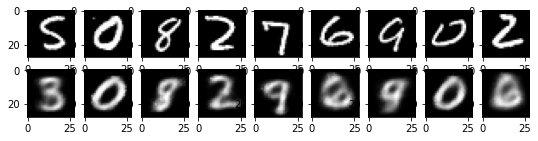

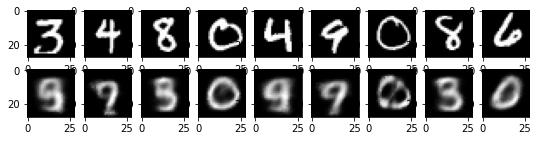

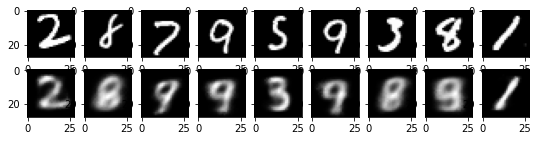

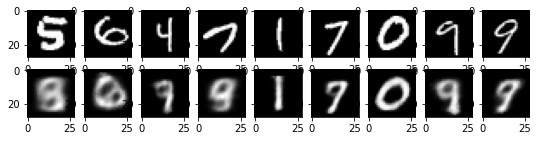

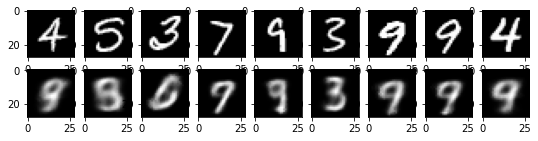

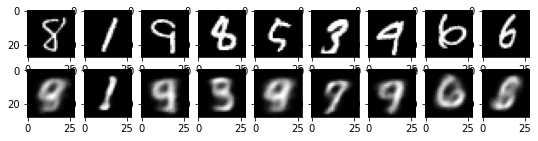

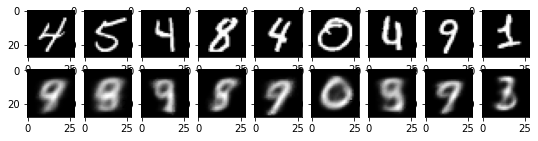

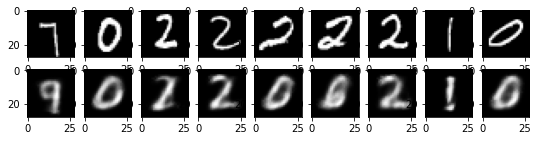

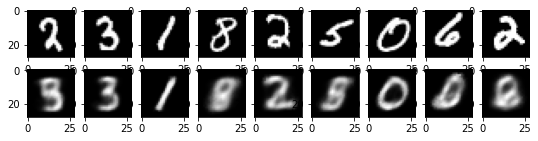

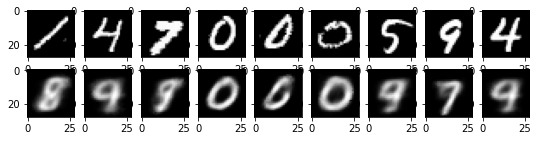

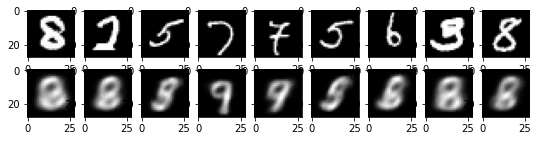

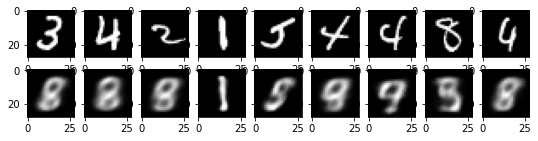

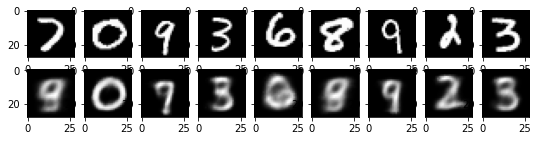

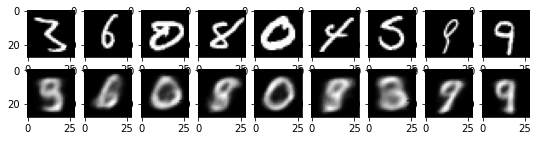

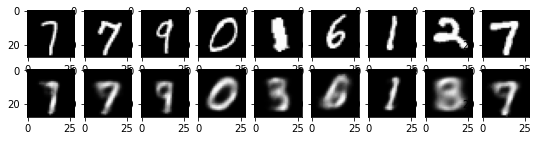

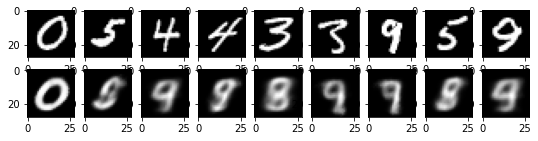

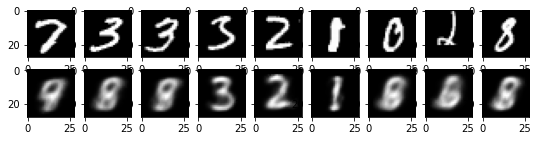

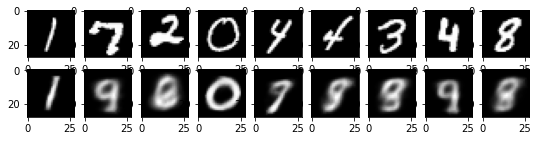

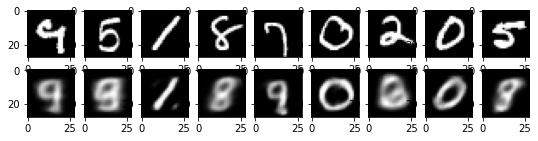

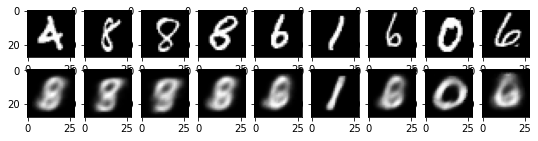

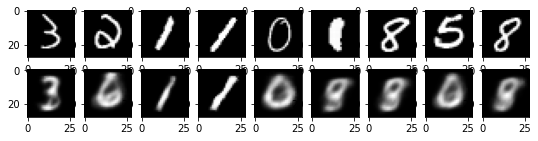

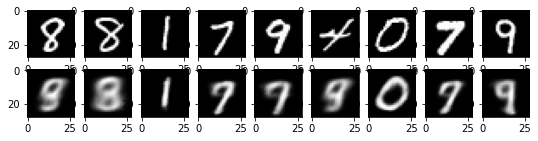

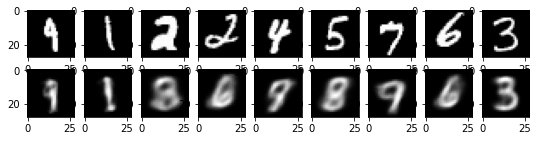

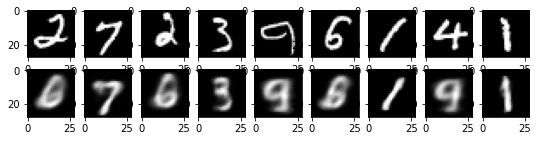

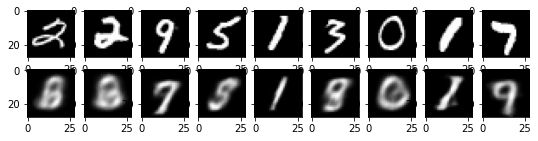

In [25]:
# To visualize the image
for k in range(0, num_epochs, 4):
    plt.figure(figsize=(9, 2))
    plt.gray()
    imgs = output1[k][1].detach().numpy()
    recon = output1[k][2].detach().numpy()
    #print(recon.shape)
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        # item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1) # row_length + i + 1
        item = item.reshape(-1, 28,28) # -> use for Autoencoder_Linear
        # item: 1, 28, 28
        plt.imshow(item[0])
        #print(item[i].size())
        #plt.show()

Text(0, 0.5, 'Training')

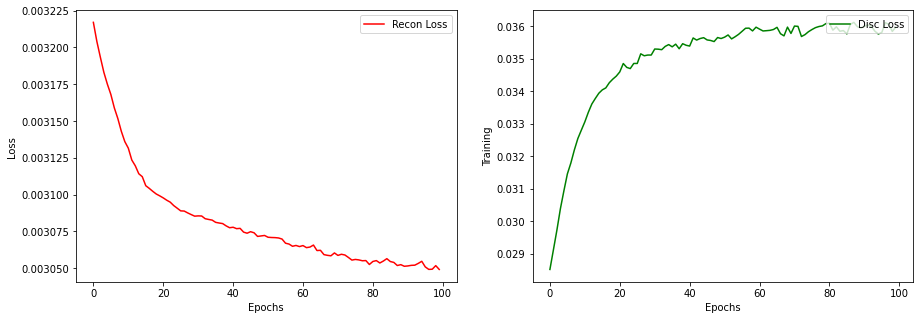

In [39]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss1,'r-',label='Recon Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(range(num_epochs),disc_loss1,'g-',label='Disc Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

# # MSE Loss Function

In [29]:
ae_criterion2 = nn.MSELoss()
train_loss2 = []
disc_loss2 = []
output2 = []

In [36]:
def MSE_training(encoder, decoder, Disc, dataloader, optim_encoder, optim_decoder, optim_D, train):
    total_rec_loss = 0
    total_disc_loss = 0
    total_gen_loss = 0
    if train:
        encoder.train()
        decoder.train()
        Disc.train()
    else:
        encoder.eval()
        decoder.eval()
        Disc.eval()

    for i, (data, labels) in enumerate(dataloader):
        """ Reconstruction loss """
        for p in Disc.parameters():
            p.requires_grad = False

        real_data_v = autograd.Variable(data)
        real_data_v = real_data_v.view(-1, 784)
        #print(real_data_v.size())
        encoding = encoder(real_data_v)
        fake = decoder(encoding)
        ae_loss = ae_criterion2(fake, real_data_v)
        total_rec_loss += ae_loss.item()
        if train:
            optim_encoder.zero_grad()
            optim_decoder.zero_grad()
            ae_loss.backward()
            optim_encoder.step()
            optim_decoder.step()

        """ Discriminator loss """
        encoder.eval()
        z_real_gauss = autograd.Variable(torch.randn(data.size()[0], 2) * 5.)
        D_real_gauss = Disc(z_real_gauss)

        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + EPS) + torch.log(1 - D_fake_gauss + EPS))
        total_disc_loss += D_loss.item()

        if train:
            optim_D.zero_grad()
            D_loss.backward()
            optim_D.step()

        """ Generator loss """
        if train:
            encoder.train()
        else:
            encoder.eval()
        z_fake_gauss = encoder(real_data_v)
        D_fake_gauss = Disc(z_fake_gauss)

        G_loss = -torch.mean(torch.log(D_fake_gauss + EPS))
        total_gen_loss += G_loss.item()

        if train:
            optim_encoder_reg.zero_grad()
            G_loss.backward()
            optim_encoder_reg.step()


        if i % 100 == 0:
            print ('\n Step [%d], recon_loss: %.4f, discriminator_loss :%.4f , generator_loss:%.4f'
                    %(i, ae_loss.item(), D_loss.item(), G_loss.item()))
            output2.append((epoch, data, fake))
    M = len(dataloader.dataset)
    return total_rec_loss /M  , total_disc_loss /M , total_gen_loss /M


In [37]:
for epoch in range(num_epochs):
    l1,l2 ,l3 = MSE_training(encoder, decoder, Disc, train_loader, optim_encoder, optim_decoder, optim_D, True)
    print('\n epoch:{} ---- training loss:{}'.format(epoch, l1))
    train_loss2.append(l1)
    disc_loss2.append(l2)


 Step [0], recon_loss: 0.0425, discriminator_loss :2.4301 , generator_loss:0.4909

 Step [100], recon_loss: 0.0442, discriminator_loss :2.3286 , generator_loss:0.5166

 Step [200], recon_loss: 0.0448, discriminator_loss :2.4135 , generator_loss:0.3613

 Step [300], recon_loss: 0.0445, discriminator_loss :2.2877 , generator_loss:0.3791

 Step [400], recon_loss: 0.0447, discriminator_loss :2.0758 , generator_loss:0.4635

 Step [500], recon_loss: 0.0449, discriminator_loss :2.1524 , generator_loss:0.4983

 Step [600], recon_loss: 0.0434, discriminator_loss :2.2368 , generator_loss:0.4557

 Step [700], recon_loss: 0.0414, discriminator_loss :2.1020 , generator_loss:0.4159

 Step [800], recon_loss: 0.0433, discriminator_loss :2.0926 , generator_loss:0.4219

 Step [900], recon_loss: 0.0470, discriminator_loss :2.4848 , generator_loss:0.4420

 epoch:0 ---- training loss:0.0007054929576193293

 Step [0], recon_loss: 0.0406, discriminator_loss :2.3493 , generator_loss:0.4302

 Step [100], reco


 Step [200], recon_loss: 0.0434, discriminator_loss :2.1853 , generator_loss:0.3913

 Step [300], recon_loss: 0.0438, discriminator_loss :2.1160 , generator_loss:0.3917

 Step [400], recon_loss: 0.0463, discriminator_loss :2.3095 , generator_loss:0.4999

 Step [500], recon_loss: 0.0453, discriminator_loss :2.0411 , generator_loss:0.5602

 Step [600], recon_loss: 0.0460, discriminator_loss :2.1779 , generator_loss:0.5044

 Step [700], recon_loss: 0.0433, discriminator_loss :2.0801 , generator_loss:0.3651

 Step [800], recon_loss: 0.0482, discriminator_loss :2.1574 , generator_loss:0.4496

 Step [900], recon_loss: 0.0416, discriminator_loss :2.4383 , generator_loss:0.4367

 epoch:9 ---- training loss:0.0006989011876285076

 Step [0], recon_loss: 0.0409, discriminator_loss :2.2904 , generator_loss:0.3852

 Step [100], recon_loss: 0.0458, discriminator_loss :2.2327 , generator_loss:0.4675

 Step [200], recon_loss: 0.0426, discriminator_loss :2.4134 , generator_loss:0.4122

 Step [300], re


 Step [400], recon_loss: 0.0491, discriminator_loss :2.1883 , generator_loss:0.4654

 Step [500], recon_loss: 0.0441, discriminator_loss :2.3990 , generator_loss:0.4613

 Step [600], recon_loss: 0.0449, discriminator_loss :2.2573 , generator_loss:0.3806

 Step [700], recon_loss: 0.0457, discriminator_loss :2.2016 , generator_loss:0.4640

 Step [800], recon_loss: 0.0416, discriminator_loss :2.4877 , generator_loss:0.5568

 Step [900], recon_loss: 0.0473, discriminator_loss :2.5965 , generator_loss:0.5420

 epoch:18 ---- training loss:0.0006974394747366508

 Step [0], recon_loss: 0.0475, discriminator_loss :2.3512 , generator_loss:0.5564

 Step [100], recon_loss: 0.0424, discriminator_loss :2.5011 , generator_loss:0.4410

 Step [200], recon_loss: 0.0431, discriminator_loss :2.6893 , generator_loss:0.4936

 Step [300], recon_loss: 0.0450, discriminator_loss :2.2118 , generator_loss:0.4676

 Step [400], recon_loss: 0.0461, discriminator_loss :2.0205 , generator_loss:0.4087

 Step [500], r


 Step [600], recon_loss: 0.0470, discriminator_loss :2.4211 , generator_loss:0.5673

 Step [700], recon_loss: 0.0443, discriminator_loss :2.1719 , generator_loss:0.4788

 Step [800], recon_loss: 0.0438, discriminator_loss :1.9886 , generator_loss:0.4188

 Step [900], recon_loss: 0.0454, discriminator_loss :2.5105 , generator_loss:0.4908

 epoch:27 ---- training loss:0.0006964314445853234

 Step [0], recon_loss: 0.0413, discriminator_loss :2.3474 , generator_loss:0.4879

 Step [100], recon_loss: 0.0458, discriminator_loss :2.5480 , generator_loss:0.3965

 Step [200], recon_loss: 0.0419, discriminator_loss :2.1685 , generator_loss:0.3623

 Step [300], recon_loss: 0.0456, discriminator_loss :2.3163 , generator_loss:0.3813

 Step [400], recon_loss: 0.0426, discriminator_loss :2.2672 , generator_loss:0.4309

 Step [500], recon_loss: 0.0425, discriminator_loss :2.1876 , generator_loss:0.4695

 Step [600], recon_loss: 0.0455, discriminator_loss :2.3001 , generator_loss:0.5127

 Step [700], r


 Step [800], recon_loss: 0.0464, discriminator_loss :1.9099 , generator_loss:0.4067

 Step [900], recon_loss: 0.0415, discriminator_loss :2.2309 , generator_loss:0.4503

 epoch:36 ---- training loss:0.0006956619187568625

 Step [0], recon_loss: 0.0454, discriminator_loss :2.0597 , generator_loss:0.4493

 Step [100], recon_loss: 0.0431, discriminator_loss :2.3199 , generator_loss:0.5051

 Step [200], recon_loss: 0.0456, discriminator_loss :2.3642 , generator_loss:0.3824

 Step [300], recon_loss: 0.0453, discriminator_loss :2.0854 , generator_loss:0.4308

 Step [400], recon_loss: 0.0468, discriminator_loss :2.3268 , generator_loss:0.4754

 Step [500], recon_loss: 0.0416, discriminator_loss :2.1968 , generator_loss:0.3876

 Step [600], recon_loss: 0.0453, discriminator_loss :2.3400 , generator_loss:0.3708

 Step [700], recon_loss: 0.0410, discriminator_loss :2.5587 , generator_loss:0.4093

 Step [800], recon_loss: 0.0469, discriminator_loss :2.3273 , generator_loss:0.4930

 Step [900], r


 epoch:45 ---- training loss:0.0006947752573837837

 Step [0], recon_loss: 0.0443, discriminator_loss :2.4104 , generator_loss:0.4596

 Step [100], recon_loss: 0.0436, discriminator_loss :2.1656 , generator_loss:0.3550

 Step [200], recon_loss: 0.0430, discriminator_loss :2.3592 , generator_loss:0.4479

 Step [300], recon_loss: 0.0441, discriminator_loss :2.2837 , generator_loss:0.5556

 Step [400], recon_loss: 0.0462, discriminator_loss :2.1928 , generator_loss:0.5194

 Step [500], recon_loss: 0.0454, discriminator_loss :2.3974 , generator_loss:0.4264

 Step [600], recon_loss: 0.0440, discriminator_loss :2.3404 , generator_loss:0.4387

 Step [700], recon_loss: 0.0394, discriminator_loss :2.2320 , generator_loss:0.3982

 Step [800], recon_loss: 0.0427, discriminator_loss :2.2855 , generator_loss:0.4891

 Step [900], recon_loss: 0.0438, discriminator_loss :2.3122 , generator_loss:0.4672

 epoch:46 ---- training loss:0.0006947684964165091

 Step [0], recon_loss: 0.0463, discriminator_lo


 Step [100], recon_loss: 0.0463, discriminator_loss :2.3768 , generator_loss:0.4992

 Step [200], recon_loss: 0.0455, discriminator_loss :2.4919 , generator_loss:0.4389

 Step [300], recon_loss: 0.0474, discriminator_loss :2.4933 , generator_loss:0.4897

 Step [400], recon_loss: 0.0453, discriminator_loss :2.3203 , generator_loss:0.5422

 Step [500], recon_loss: 0.0433, discriminator_loss :2.2092 , generator_loss:0.5343

 Step [600], recon_loss: 0.0452, discriminator_loss :2.2935 , generator_loss:0.4521

 Step [700], recon_loss: 0.0429, discriminator_loss :2.5282 , generator_loss:0.4893

 Step [800], recon_loss: 0.0441, discriminator_loss :2.3555 , generator_loss:0.3975

 Step [900], recon_loss: 0.0449, discriminator_loss :2.5540 , generator_loss:0.3836

 epoch:55 ---- training loss:0.0006954407524938385

 Step [0], recon_loss: 0.0406, discriminator_loss :2.1375 , generator_loss:0.4656

 Step [100], recon_loss: 0.0399, discriminator_loss :2.2422 , generator_loss:0.5025

 Step [200], r


 Step [300], recon_loss: 0.0448, discriminator_loss :2.1248 , generator_loss:0.4805

 Step [400], recon_loss: 0.0448, discriminator_loss :2.2428 , generator_loss:0.5072

 Step [500], recon_loss: 0.0456, discriminator_loss :2.2154 , generator_loss:0.5393

 Step [600], recon_loss: 0.0450, discriminator_loss :2.2936 , generator_loss:0.5311

 Step [700], recon_loss: 0.0428, discriminator_loss :2.5363 , generator_loss:0.6395

 Step [800], recon_loss: 0.0432, discriminator_loss :2.3229 , generator_loss:0.4371

 Step [900], recon_loss: 0.0456, discriminator_loss :2.3532 , generator_loss:0.4027

 epoch:64 ---- training loss:0.0006952218520144621

 Step [0], recon_loss: 0.0433, discriminator_loss :2.2368 , generator_loss:0.3698

 Step [100], recon_loss: 0.0423, discriminator_loss :2.3392 , generator_loss:0.4803

 Step [200], recon_loss: 0.0418, discriminator_loss :2.5190 , generator_loss:0.4055

 Step [300], recon_loss: 0.0462, discriminator_loss :2.3284 , generator_loss:0.5172

 Step [400], r


 Step [500], recon_loss: 0.0444, discriminator_loss :2.3252 , generator_loss:0.3822

 Step [600], recon_loss: 0.0461, discriminator_loss :2.1026 , generator_loss:0.5111

 Step [700], recon_loss: 0.0434, discriminator_loss :2.3946 , generator_loss:0.4945

 Step [800], recon_loss: 0.0459, discriminator_loss :2.5675 , generator_loss:0.4424

 Step [900], recon_loss: 0.0456, discriminator_loss :2.1540 , generator_loss:0.5225

 epoch:73 ---- training loss:0.0006955655381083489

 Step [0], recon_loss: 0.0440, discriminator_loss :2.2927 , generator_loss:0.4995

 Step [100], recon_loss: 0.0468, discriminator_loss :2.0666 , generator_loss:0.4112

 Step [200], recon_loss: 0.0454, discriminator_loss :2.3089 , generator_loss:0.4802

 Step [300], recon_loss: 0.0431, discriminator_loss :2.3443 , generator_loss:0.4381

 Step [400], recon_loss: 0.0437, discriminator_loss :2.3551 , generator_loss:0.5051

 Step [500], recon_loss: 0.0448, discriminator_loss :2.2738 , generator_loss:0.4301

 Step [600], r


 Step [700], recon_loss: 0.0468, discriminator_loss :2.2805 , generator_loss:0.4730

 Step [800], recon_loss: 0.0441, discriminator_loss :1.9288 , generator_loss:0.5008

 Step [900], recon_loss: 0.0454, discriminator_loss :2.3796 , generator_loss:0.4105

 epoch:82 ---- training loss:0.0006946517759934068

 Step [0], recon_loss: 0.0458, discriminator_loss :2.3585 , generator_loss:0.4848

 Step [100], recon_loss: 0.0485, discriminator_loss :2.4386 , generator_loss:0.4043

 Step [200], recon_loss: 0.0465, discriminator_loss :2.1680 , generator_loss:0.4697

 Step [300], recon_loss: 0.0461, discriminator_loss :2.0513 , generator_loss:0.4215

 Step [400], recon_loss: 0.0425, discriminator_loss :2.4126 , generator_loss:0.5900

 Step [500], recon_loss: 0.0456, discriminator_loss :2.1790 , generator_loss:0.4314

 Step [600], recon_loss: 0.0438, discriminator_loss :2.1219 , generator_loss:0.4767

 Step [700], recon_loss: 0.0466, discriminator_loss :2.0776 , generator_loss:0.4306

 Step [800], r


 Step [900], recon_loss: 0.0489, discriminator_loss :1.9721 , generator_loss:0.4938

 epoch:91 ---- training loss:0.0006950516514480114

 Step [0], recon_loss: 0.0494, discriminator_loss :2.0749 , generator_loss:0.4261

 Step [100], recon_loss: 0.0444, discriminator_loss :2.1443 , generator_loss:0.4999

 Step [200], recon_loss: 0.0489, discriminator_loss :2.3666 , generator_loss:0.4389

 Step [300], recon_loss: 0.0475, discriminator_loss :2.3278 , generator_loss:0.4389

 Step [400], recon_loss: 0.0451, discriminator_loss :2.2754 , generator_loss:0.4207

 Step [500], recon_loss: 0.0415, discriminator_loss :2.2930 , generator_loss:0.4334

 Step [600], recon_loss: 0.0448, discriminator_loss :2.3312 , generator_loss:0.4465

 Step [700], recon_loss: 0.0427, discriminator_loss :2.2531 , generator_loss:0.4627

 Step [800], recon_loss: 0.0454, discriminator_loss :2.2717 , generator_loss:0.3929

 Step [900], recon_loss: 0.0444, discriminator_loss :2.1633 , generator_loss:0.4040

 epoch:92 ----

Text(0, 0.5, 'Training')

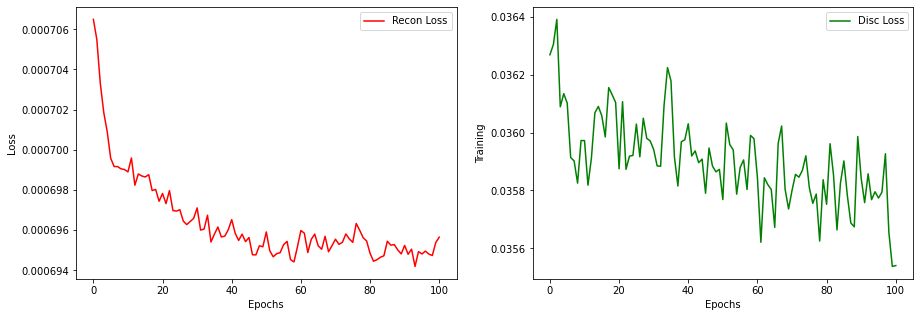

In [43]:
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs+1),train_loss2,'r-',label='Recon Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(122)
plt.plot(range(num_epochs+1),disc_loss2,'g-',label='Disc Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Training')

1. Reconstruction loss is a check of how well the image has been reconstructed from the input.

2. Reconstruction loss will be high at the beginning and gradually learn the parameters to reconstruct the inputs and at certain level it will get some saturation point , no change any more.

3. Discriminator loss will be high at the beginning and then get down in the graph by predicted the real and fake but when the adverserial loss gradually incresing , it will fool the discriminator so that it can't distinguish between real and fake.

4. So discriminator loss will get increasing gradually and at certain level it will get some saturation point , no change any more

# # Question No 3

In [44]:
class all(nn.Module):
    def __init__(self):
        super(all,self).__init__()
        self.l1 = encoder
        self.l2 = nn.Linear(2,10)
        
    def forward(self,x):
        x=self.l1(x)
        x=self.l2(x)
        return x

In [45]:
net = all()
print(net)

all(
  (l1): Q_net(
    (lin1): Linear(in_features=784, out_features=1000, bias=True)
    (lin2): Linear(in_features=1000, out_features=1000, bias=True)
    (lin3gauss): Linear(in_features=1000, out_features=2, bias=True)
  )
  (l2): Linear(in_features=2, out_features=10, bias=True)
)


In [46]:
crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [52]:
n_epochs1 = 30

for epoch in range(n_epochs1):
    running_loss = 0.0 
    
        
    for i,data in enumerate(train_loader,0):
        inputs,labels = data
        inputs,labels = inputs.view(inputs.size(0),-1), labels
        net.train()
        # Initializing model gradients to zero
        optimizer.zero_grad() 
        # Data feed-forward through the network
        outputs = net(inputs)
        loss = crit(outputs, labels)
        loss.backward()
        optimizer.step()
        correct = 0
        total = 0
    for data in test_loader:
        net.eval()
        inputs,labels = data
        inputs,labels = inputs.view(inputs.size(0),-1), labels.view(labels.size(0),-1)
    
    # Feedforward train data batch through model
        outputs = net(inputs) 
        _,predicted = torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted == labels.data).sum()
    
    test_accuracy = correct.item()/10000.0
    print('\n epoch: %d ----Testing accuracy : %f  '%(epoch ,test_accuracy*10)) 


 epoch: 0 ----Testing accuracy : 69.738000  

 epoch: 1 ----Testing accuracy : 69.387000  

 epoch: 2 ----Testing accuracy : 69.173000  

 epoch: 3 ----Testing accuracy : 69.735000  

 epoch: 4 ----Testing accuracy : 69.677000  

 epoch: 5 ----Testing accuracy : 68.674000  

 epoch: 6 ----Testing accuracy : 69.904000  

 epoch: 7 ----Testing accuracy : 69.369000  

 epoch: 8 ----Testing accuracy : 69.651000  

 epoch: 9 ----Testing accuracy : 69.789000  

 epoch: 10 ----Testing accuracy : 69.314000  

 epoch: 11 ----Testing accuracy : 69.750000  

 epoch: 12 ----Testing accuracy : 68.657000  

 epoch: 13 ----Testing accuracy : 69.632000  

 epoch: 14 ----Testing accuracy : 69.511000  

 epoch: 15 ----Testing accuracy : 69.590000  

 epoch: 16 ----Testing accuracy : 69.226000  

 epoch: 17 ----Testing accuracy : 69.739000  

 epoch: 18 ----Testing accuracy : 69.887000  

 epoch: 19 ----Testing accuracy : 69.456000  

 epoch: 20 ----Testing accuracy : 69.920000  

 epoch: 21 ----Testing

Text(0, 0.5, 'loss')

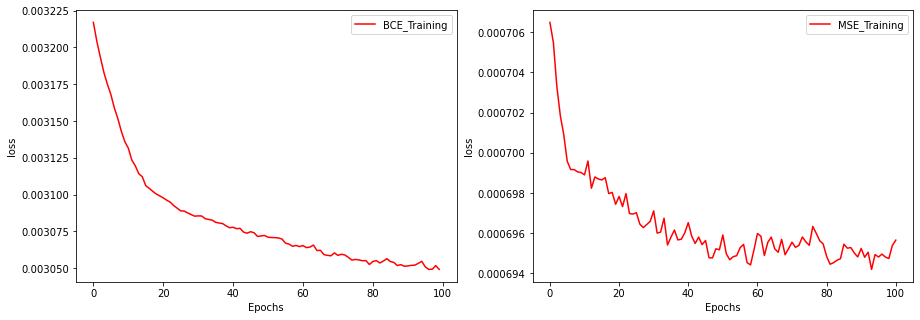

In [63]:
#Plot the training accuracy and loss values
fig = plt.figure(figsize=[15,5]) 
plt.subplot(121)
plt.plot(range(num_epochs),train_loss1,'r-', label = 'BCE_Training') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.subplot(122)
plt.plot(range(num_epochs+1),train_loss2,'r-', label = 'MSE_Training') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('loss')

Training Process

1. A new network is trained to discriminatively predict whether a sample comes from the hidden code of the autoencoder or from the prior distribution P(z)determined by the user.

2. The loss of the encoder is now composed by the reconstruction loss plus the loss given by the discriminator network.

3. On the adversarial regularization part the discriminator recieves z distributed as q(z/x) and z' sampled from the true prior p(z) and assigns a probability to each of coming from p(z).

4. The loss incurred is backpropagated through the discriminator to update its weights. Then the process is repeated and the generator updates its parameters.